In [1]:
import os
import sys
sys.path.append('/Users/mnannan/dev/supelec/ngsa/assignments/Assignement 2 ')

from main import pipeline
from core.io.loader import *
from features.features_extractor import FeaturesExtractor
from features.processing import features_processing
from models.cross_validation import *
from plot.features_importances import plot_features_importance

from datetime import datetime

%matplotlib inline



## Load dataset and extract features

In [2]:
train = get_data_with_node_information('train', data_dir='../data')
test = get_data_with_node_information('test', data_dir='../data')
features_extractor = FeaturesExtractor(pipeline)
train = features_extractor.fit_transform(train)
test = features_extractor.transform(test)

## Features selection

In [3]:
selected_columns = [
    'title_overlap',
    'publication_date_diff',
    'common_authors',
    'same_journal',
    'authors_collaboration',
    'collaboration_min_distance',
    'collaboration_mean_distance',
    'writer_in_target_paper',
    'writer_collaborators',
    'writer_collaboration_min_distance',
    'writer_collaboration_mean_distance',
    'source_paper_citations',
    'target_paper_citations',
    'source_number_of_papers_cited',
    'target_number_of_papers_cited',
    'adamic_adar',
    'common_neighbors',
    'jaccard_coefficient',
    'preferential_attachment',
    'max_authors_adamic_adar',
    'max_authors_common_neighbors',
    'max_authors_jaccard_coefficient',
    'max_authors_preferential_attachment'
]

x_train = features_processing(train[selected_columns]).values
x_test = features_processing(test[selected_columns]).values
y_train = train.category.values

### Model selection

In [4]:
from sklearn.ensemble import RandomForestClassifier

seed = 123

model_args = {
    'n_jobs': -1,
    'n_estimators': 100,
    'random_state': seed,
    'criterion': 'entropy'
}

### Cross validation

In [5]:
y_pred, f1_list = cross_validation(RandomForestClassifier, model_args, x_train, y_train)

Epoch 1
f1: 0.9720812756813813
Epoch 2
f1: 0.9728234582829505
Epoch 3
f1: 0.9718803598832486
Epoch 4
f1: 0.9726797395483594
Epoch 5
f1: 0.972702168434713


In [6]:
np.mean(f1_list)

0.9724334003661305

### Train final model

adamic_adar                            0.285873
jaccard_coefficient                    0.217053
common_neighbors                       0.153613
publication_date_diff                  0.073702
preferential_attachment                0.058146
target_paper_citations                 0.056090
source_number_of_papers_cited          0.034401
target_number_of_papers_cited          0.018899
title_overlap                          0.016194
source_paper_citations                 0.014723
collaboration_mean_distance            0.014133
max_authors_preferential_attachment    0.013040
writer_collaboration_mean_distance     0.012342
collaboration_min_distance             0.010702
writer_collaboration_min_distance      0.007347
max_authors_jaccard_coefficient        0.002879
max_authors_adamic_adar                0.002557
max_authors_common_neighbors           0.002406
common_authors                         0.001467
same_journal                           0.001454
authors_collaboration                  0

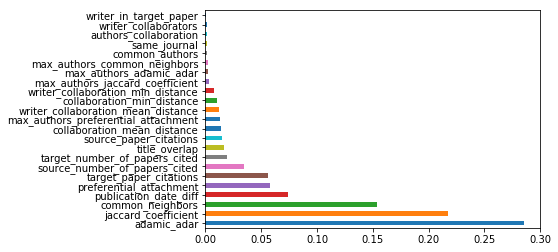

In [7]:
model = RandomForestClassifier(**model_args)
model.fit(x_train, y_train)
plot_features_importance(model.feature_importances_, selected_columns)

### Prediction on test

In [8]:
from datetime import datetime

In [9]:
date = datetime.now().isoformat().split(".")[0]
prediction_name = 'rf_graph_features_neighborhood_metrics_authors_neighborhood_metrics{date}.csv'.format(date=date)
prediction_dir = '../submissions'
y_pred = model.predict(x_test)
y_pred = pd.Series(data=y_pred).rename('category').rename_axis('id', axis='index')
y_pred.to_csv(os.path.join(prediction_dir, prediction_name), header=True)

# 0.96085 on the leaderboard